In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train_est_A = pd.read_csv('train_est_C.csv')
df_train_obs_A = pd.read_csv('train_obs_C.csv')
df_test_A = pd.read_csv('X_test_C.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)


In [3]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)


In [4]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [7]:
columns = df.drop(columns = 'pv_measurement').columns

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Crea un oggetto MinMaaxScaler
scaler = MinMaxScaler()
# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_normalized['pv_measurement'] =  df_knn['pv_measurement'] - df_knn['pv_measurement'].shift(1)


In [9]:
df = df_normalized
df = df.fillna(0)

In [10]:
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df['dayofyear'] = df.index.day_of_year
df_test_A['dayofyear'] = df_test_A.index.day_of_year

In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
data = df
n_splits = 3
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [12]:
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
param = {'verbose' : -1}
# Definisci il modello di machine learning
model = lgb.LGBMRegressor(**param)

# Definisci il selezionatore di feature
rfe = RFE(estimator=model, n_features_to_select=None)

# Trova il numero migliore di feature in base al MAE
errors = []
for n_features in range(1, len(df.columns)):
    rfe.n_features_to_select = n_features
    print("Numero di Feature usate: ",n_features)
    # Calcola il MAE utilizzando la cross-validation
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        rfe.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rfe.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        maelist.append(mae)
    # Calcola il MAE medio
    mean_mae = np.mean(maelist)
    print("MAE medio : ",mae)
    errors.append(mae)

Numero di Feature usate:  1
MAE medio :  13.688993968733177
Numero di Feature usate:  2
MAE medio :  11.885288008359542
Numero di Feature usate:  3
MAE medio :  11.672538847841194
Numero di Feature usate:  4
MAE medio :  11.683562505153407
Numero di Feature usate:  5
MAE medio :  11.66848147490437
Numero di Feature usate:  6



KeyboardInterrupt



In [ ]:
min_index = errors.index(min(errors))
errros_df = pd.DataFrame(errors)
n_features = min_index + 1
n_features

In [ ]:
selected_features = rfe.get_feature_names_out()
selected_features

In [ ]:
data = df[selected_features]
data['pv_measurement'] = df["pv_measurement"]

In [ ]:
# Traina il modello sulle feature selezionate
model.fit(data[selected_features], df["pv_measurement"])
# Calcola il MAE con le feature selezionate
y_pred = model.predict(data[selected_features])
mae = mean_absolute_error(data["pv_measurement"], y_pred)
print("Il numero migliore di feature è:", n_features)
print("Il MAE con il numero di feature ottimale è:", mae)

In [ ]:
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)

    return mae

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

In [ ]:
study.optimize(objective, n_trials=50)

In [62]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 16.61941594039391
{'n_estimators': 769, 'reg_alpha': 0.001058790170852314, 'reg_lambda': 0.17064028739534656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009497496270593646, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 120, 'min_data_per_groups': 64}


In [63]:
param = {'n_estimators': 769, 'reg_alpha': 0.001058790170852314, 'reg_lambda': 0.17064028739534656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009497496270593646, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 120, 'min_data_per_groups': 64}

In [64]:
model_A = lgb.LGBMRegressor(**param)

In [65]:
df_test_A = df_test_A[selected_features]
df_test_A.shape

(720, 35)

In [66]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']
X_train.shape

(31599, 35)

In [69]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7538
[LightGBM] [Info] Number of data points in the train set: 31599, number of used features: 35
[LightGBM] [Info] Start training from score 87.972699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


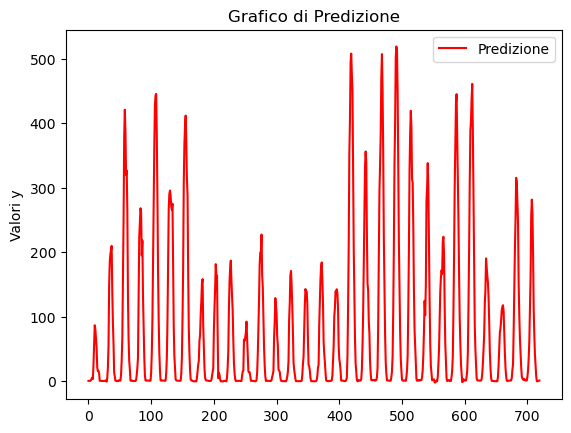

In [70]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [75]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [76]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [77]:
df.to_csv('C.csv')

In [78]:
df.head(50)


Prediction
0     0.120171
1     0.120171
2     0.120171
3     0.125308
4     1.301581
5     3.125103
6     5.349928
7     2.846190
8    24.482791
9    55.897179
10   86.446812
11   80.114767
12   66.558749
13   51.598934
14   20.900851
15   15.371990
16   15.750614
17   11.704341
18    0.276455
19    0.146693
20    0.000000
21    0.000000
22    0.099036
23    0.084418
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    1.182689
29    0.000000
30    4.500466
31   20.887284
32   54.718182
33  148.430040
34  185.221547
35  197.334044
36  203.502675
37  209.757141
38  138.870633
39   90.058618
40   57.555428
41   13.186585
42    7.103376
43    0.540945
44    0.348806
45    0.000000
46    0.000000
47    0.000000
48    0.850472
49    0.551807